<IPython.core.display.Javascript object>


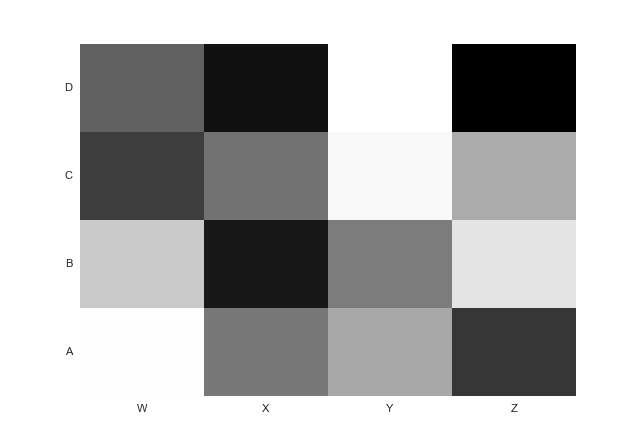

In [84]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
from scipy import stats
from sklearn.neighbors.kde import KernelDensity

column_labels = list('ABCD')
row_labels = list('WXYZ')
data = np.random.rand(4,4)
fig, ax = plt.subplots()
heatmap = ax.pcolor(data)

# put the major ticks at the middle of each cell, notice "reverse" use of dimension
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)


ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()

In [3]:
import datetime as dt
import util
import pandas as pd
import seaborn as sns; sns.set()

sd = dt.date(2005,1,1)
ed = dt.datetime(2017,12,31)
dates = pd.date_range(sd, ed)
syms = ['GOOG','AAPL','TSLA','MSFT','AMD','HPQ','INTC','AKAM']
sym = 'AAPL'
#util.update_data(syms)
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])

In [4]:
df.head()

,Close
Date,
2005-01-03,4.52
2005-01-04,4.57
2005-01-05,4.61
2005-01-06,4.61
2005-01-07,4.95


In [157]:
def profitmap(year,df):
    A=np.zeros( (252,252) )
    for x in range(0,252):
        for y in range(0,252):
            sd = dt.date(year,1,1)+dt.timedelta(x)
            ed = dt.date(year,1,1)+dt.timedelta(y)
            if y<x:
                ed = dt.date(year,1,1)+dt.timedelta(y+365)
            if sd in df.index and ed in df.index:
                A[x][y]=(df.loc[ed]/df.loc[sd]) -1
    return A


def profitmap2(year,df):
    sy = dt.date(year,1,1)
    data = df[sy:]
    A=np.zeros( (252,252))
    for x in range(0,252):
        for y in range(0,252):
            si = x
            ei = si + y
            A[x,y]=(data.ix[ei]/data.ix[si])
    return A

def profit_density(profit_map,min_ret=0.1,max_ret=1.0):
    density_map = list()
    for row in range(0,252):
        a = profit_map[row]-1
        x= np.linspace(a.min(),a.max(), num=252)
        kernel = stats.gaussian_kde(a)
        density_map.append(kernel.integrate_box_1d(min_ret,max_ret))
    return density_map

In [6]:

import time

start = time.time()
A= profitmap2(2015,df)
end = time.time()

print(end - start)

22.3090000153


In [64]:
N = 20
X = np.concatenate((np.random.normal(0, 1, 0.3 * N),
                    np.random.normal(5, 1, 0.7 * N)))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]




C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [123]:
sym='AAPL'
df = pd.DataFrame(web.DataReader(sym, 'google', sd, ed)['Close'])
A= profitmap2(2015,df)
B = profitmap2(2014,df)

<IPython.core.display.Javascript object>


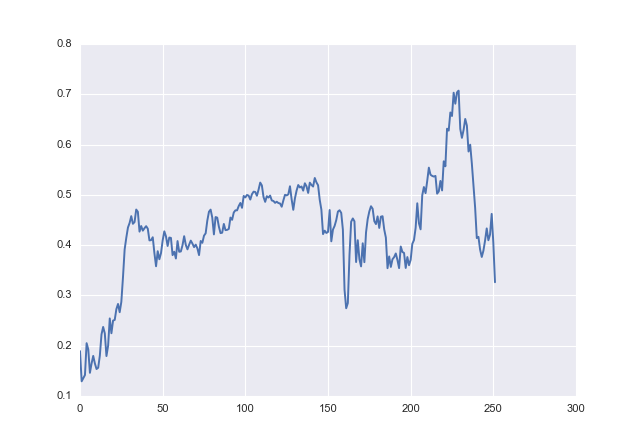

<IPython.core.display.Javascript object>


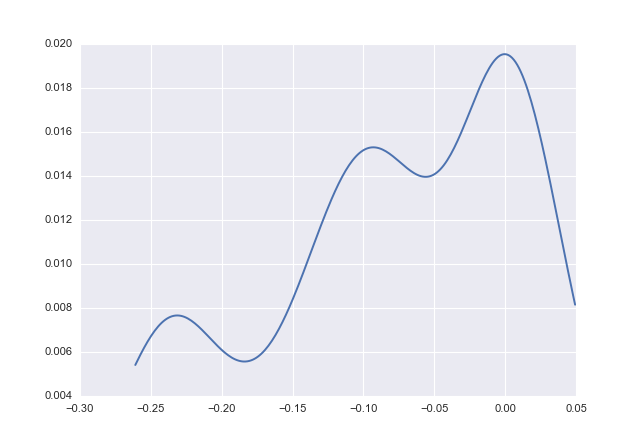

0.00125424882574


In [117]:
a=A[42]-1
#a=a.reshape(-1,1)
#kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(a)
x= np.linspace(a.min(),a.max(), num=252)
#dens = np.exp(kde.score_samples(x))
kernel = stats.gaussian_kde(a)
fig, ax = plt.subplots()
ax.plot(x,kernel.evaluate(x)/252.)
plt.show()

print kernel.integrate_box_1d(.1,5)

<IPython.core.display.Javascript object>


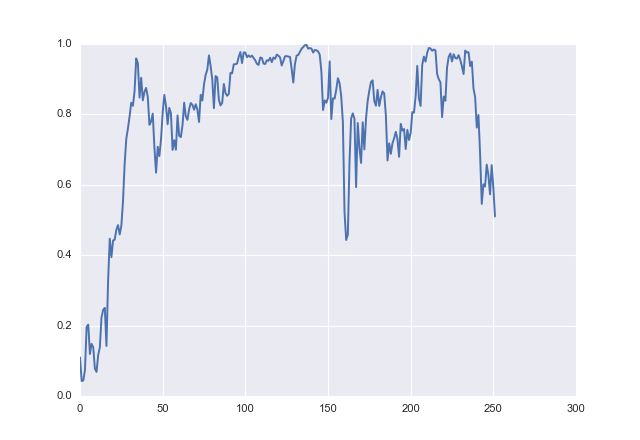

In [121]:
fig, ax = plt.subplots()
ax.plot(profit_density(A))
plt.show()

In [128]:
sym_profitmap = lambda x: profitmap2(x,df)
maps = map(sym_profitmap,range(2005,2015))


<IPython.core.display.Javascript object>


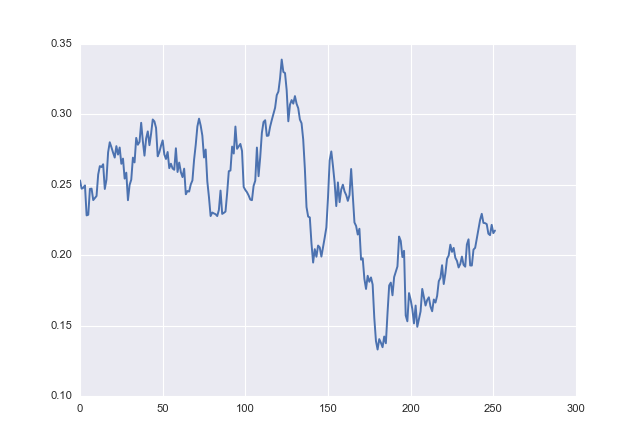

In [162]:
C=np.hstack(maps)
fig, ax = plt.subplots()
ax.plot(profit_density(C,0.4,5))
plt.show()

In [ ]:
year = 2014
sy = dt.date(year,1,1)          
data = df[sy:]
print data.ix[244]

In [ ]:
df['FNCL'].index[2500]

In [ ]:
goog_profitmap = lambda x: profitmap2(x,df['AKAM'])
maps = map(goog_profitmap,range(2005,2015))
A=sum(np.log(maps))
A=A/len(maps)
A= (10 ** A) -1 


In [ ]:
B=A[:,:100]
fig, ax = plt.subplots()
ax = sns.heatmap(B,xticklabels=5,yticklabels=15)

In [160]:
def examine_year(year,sym,si,ei):
    sy = dt.date(year,1,1)   
    data = df[sym][sy:]
    a= data.ix[si]
    b= data.ix[si + ei]
    print a,b, b/a, ((b/a) -1) * 100 
    print data.index[si],data.index[si+ei]

eyear = lambda year: examine_year(year,'AKAM',121,34)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(eyear, year=(2005,2017));

KeyError: 'AKAM'

In [ ]:
a=enumerate(df['AAPL'][dt.date(2017,1,1):].index)
[x for x in a]

In [ ]:
np.argmax(A[84, ])
A[84,173]